In [1]:
import math
import os
import random
import utils
import config

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# For GCN-LSTM model
import tensorflow as tf
from tensorflow import keras
from keras import Model, initializers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import stellargraph as sg
from stellargraph.layer import GCN_LSTM

# For hyperopt (parameter optimization)
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from hyperopt.pyll.base import scope  # quniform returns float, some parameters require int; use this to force int

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

%matplotlib inline

In [2]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
def format_scale_data(data, seq_len=1):
    X_total = data.values

    X_total = X_total[(53-seq_len):, :]
    scaler, X_total_scaled = utils.scale(X_total)
    data = X_total_scaled.T
    
    X, y = utils.sequence_data_preparation(seq_len, 1, data)
    y = y[:, 1].reshape((-1, 1))
    features = 13
    obs = seq_len*features

    trainX = X[:140, :, :]
    trainY = y[:140, :]
    validX1 = X[140:144, :, :]
    validY1 = y[140:144, :]
    validX2 = X[144:148, :, :]
    validY2 = y[144:148, :]
    testX = X[148:, :, :]
    testY = y[148:, :]
    
    print(trainX.shape, validX1.shape, validX2.shape, testX.shape)
    print(trainY.shape, validY1.shape, validY2.shape, testY.shape)
    
    y_scaler, y2 = utils.scale(X_total[:, 1].reshape((len(X_total), 1)))
    y2 = X_total[:, -features:]
    print(y2.shape)
    
    return trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler

In [6]:
def load_eval_model(name, w, output):
    gcn_lstm = load_model('Model/{}'.format(name))
    print(gcn_lstm.summary())
    
    # load data
    saltlake_week = pd.read_csv('../saltlake_week.csv')
    data = saltlake_week[['Cases', 'VMT (Veh-Miles)', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                          'Percent_Fully_Vaccinated_5&Older', 'TAVG', 
                          'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']]
    trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler = format_scale_data(data=data, 
                                                                                                            seq_len=w)
    
    # evaluate model on second validation set
    gcn_lstm.evaluate(validX2, validY2)
    
    # invert predictions of model
    yhat_valid2 = gcn_lstm.predict(validX2)[:, 1].reshape((-1, 1))
    yhat_valid2_inv = y_scaler.inverse_transform(yhat_valid2)
    validY2_inv = y_scaler.inverse_transform(validY2.reshape((-1, 1)))
    
    print(yhat_valid2)
    print(yhat_valid2_inv)
    print(validY2_inv)
    
    yhat_train = gcn_lstm.predict(trainX)[:, 1].reshape((-1, 1))
    yhat_train_inv = y_scaler.inverse_transform(yhat_train)
    trainY_inv = y_scaler.inverse_transform(trainY.reshape((-1, 1)))
    
    # evaluate model with inverted features
    print("Mean Squared Error: {}".format(mean_squared_error(validY2_inv, yhat_valid2_inv)))
    print("Root Mean Squared Error: {}".format(mean_squared_error(validY2_inv, yhat_valid2_inv, squared=False)))
    print("Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(validY2_inv, yhat_valid2_inv)))
    
    # plot model predictions
    plt.figure()
    plt.plot(yhat_valid2_inv, label='Predicted')
    plt.plot(validY2_inv, label='True')
    plt.legend()
    plt.title("Validation Data 2")
    plt.show()
    
    plt.figure()
    plt.plot(yhat_train_inv, label='Predicted')
    plt.plot(trainY_inv, label='True')
    plt.legend()
    plt.title("Training Data")
    plt.show()
    
    utils.plot_predicted(validY2_inv, yhat_valid2_inv, "{} Validation Data 2".format(name), output)

Model: "model_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_219 (InputLayer)      [(None, 13, 3)]           0         
                                                                 
 tf.expand_dims_109 (TFOpLam  (None, 13, 3, 1)         0         
 bda)                                                            
                                                                 
 reshape_327 (Reshape)       (None, 13, 3)             0         
                                                                 
 fixed_adjacency_graph_convo  (None, 13, 6)            200       
 lution_218 (FixedAdjacencyG                                     
 raphConvolution)                                                
                                                                 
 fixed_adjacency_graph_convo  (None, 13, 16)           278       
 lution_219 (FixedAdjacencyG                             

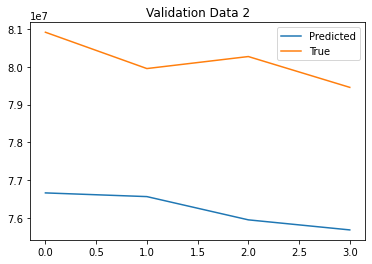

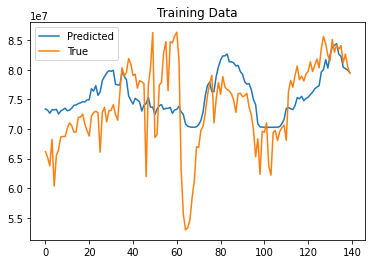

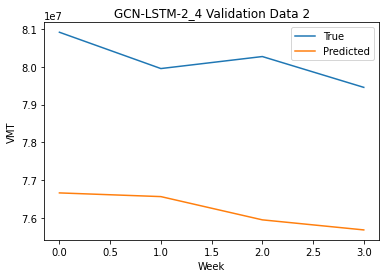

In [8]:
load_eval_model('GCN-LSTM-2_4', 3, 'output/gcn_lstm_2_4_val2_new.jpg')